In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('JPM', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,35.189999,34.009998,34.060001,34.980000,44102800.0,26.391466
2012-01-04,35.150002,34.330002,34.439999,34.950001,36571200.0,26.558649
2012-01-05,35.919998,34.400002,34.709999,35.680000,38381400.0,27.113379
2012-01-06,35.770000,35.139999,35.689999,35.360001,33160600.0,26.870209
2012-01-09,35.680000,34.990002,35.439999,35.299999,23001800.0,26.824614
...,...,...,...,...,...,...
2022-03-01,140.479996,133.580002,140.039993,136.449997,36840400.0,136.449997
2022-03-02,140.039993,136.610001,137.289993,139.279999,19405600.0,139.279999
2022-03-03,140.979996,137.059998,139.839996,138.289993,16640800.0,138.289993


In [19]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2049

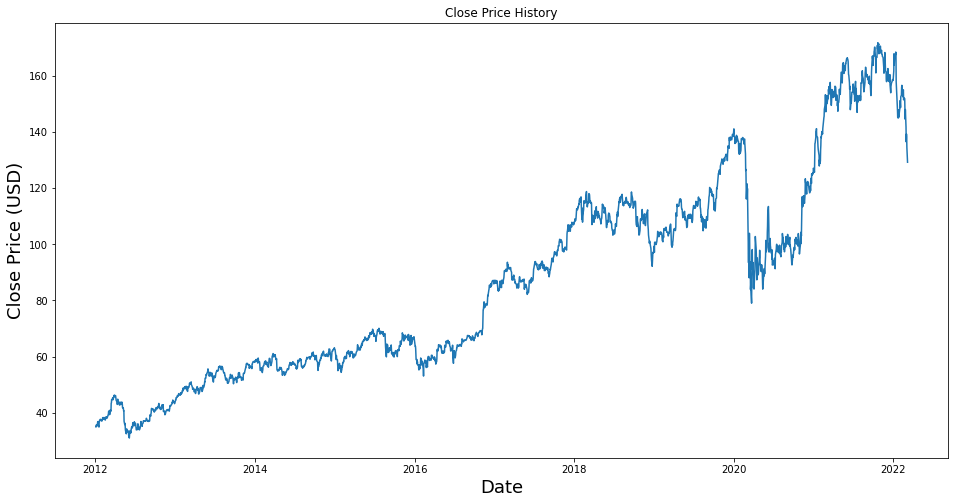

In [20]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02827106],
       [0.02805797],
       [0.03324336],
       ...,
       [0.76211105],
       [0.73447929],
       [0.69761335]])

In [22]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.02827106, 0.02805797, 0.03324336, 0.03097031, 0.03054411,
       0.03587157, 0.04020457, 0.04155419, 0.03494813, 0.02777383,
       0.03935219, 0.04212246, 0.04517688, 0.04730786, 0.04730786,
       0.04688165, 0.04610031, 0.04411137, 0.04269071, 0.04475067,
       0.04688165, 0.04652649, 0.05171188, 0.05071743, 0.04879954,
       0.05185395, 0.04872852, 0.0469527 , 0.05185395, 0.0491547 ,
       0.04546101, 0.04972297, 0.05306152, 0.05299048, 0.0502202 ,
       0.05320359, 0.05171188, 0.05725246, 0.05831794, 0.05853105,
       0.06655774, 0.06840461, 0.06677086, 0.0590993 , 0.06357438,
       0.06705497, 0.07124591, 0.06776531, 0.08800966, 0.0893593 ,
       0.09731497, 0.09639153, 0.09944594, 0.1021452 , 0.10029833,
       0.09695981, 0.10058247, 0.10775677, 0.10576786, 0.10846712])]
[0.1042051306730277]



In [23]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [24]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1989, 60, 1)

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [26]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [27]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1989/1989 [==============================] - 35s 17ms/step - loss: 0.0010


In [28]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [29]:
x_test = np.array(x_test)

In [30]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [32]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.5058731883764267

C:\Users\kapoo\AppData\Local\Temp/ipykernel_3848/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


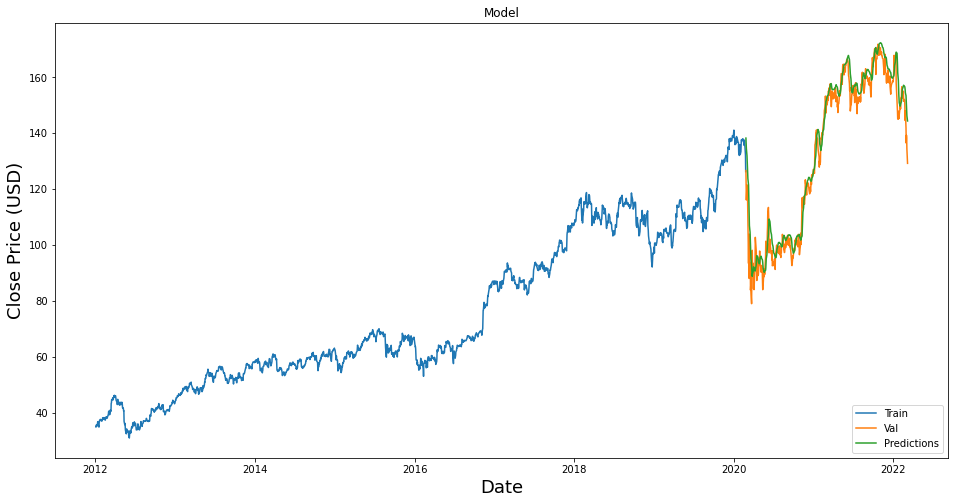

In [33]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [34]:
valid

,Close,Predictions
Date,,
2020-02-26,126.639999,138.239395
2020-02-27,121.370003,136.652893
2020-02-28,116.110001,134.556244
2020-03-02,121.519997,131.869125
2020-03-03,116.959999,129.598816
...,...,...
2022-03-01,136.449997,151.952789
2022-03-02,139.279999,149.916122
2022-03-03,138.289993,148.000900


In [35]:
jpm_quote = web.DataReader('JPM', data_source='yahoo',start='2012-01-01', end='2022-03-07')
new_df = jpm_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[142.12721]]


In [36]:
jpm_quote2 = web.DataReader('JPM', data_source='yahoo',start='2022-03-01', end='2022-03-07')
print(jpm_quote2['Close'])

Date
2022-02-28    141.800003
2022-03-01    136.449997
2022-03-02    139.279999
2022-03-03    138.289993
2022-03-04    134.399994
2022-03-07    129.210007
Name: Close, dtype: float64
